# Anxiety prediction using HMMs for temporal data aggregation

In [2]:
import pandas as pd
import numpy as np
import joblib as jbl

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import pyhhmm.utils as hu
from src.utils import *

import warnings
warnings.filterwarnings("ignore")

# set autoreload
%load_ext autoreload
%autoreload 2

## Define hyper-parameter grids

In [22]:
# define hyper-parameter grid for LR
lr_param_grid = {
    "lr__penalty": ["l1", "l2", "elasticnet"],
    "lr__C" : [0.001, 0.01, 0.1, 1, 10, 100],
    "lr__l1_ratio": [0.001, 0.01, 0.1, 0.5, 0.75],
    "lr__class_weight" : ["balanced", None],
    "lr__solver": ["liblinear", "saga"]
}

# define hyper-parameter grid for RF
rfc_param_grid = {
    "rfc__n_estimators": [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
    "rfc__max_features": ["auto", "sqrt"],
    "rfc__max_depth" : [None] + [int(x) for x in np.linspace(5, 100, num = 10)],
    "rfc__min_samples_split": [2, 5, 10, 15],
    "rfc__min_samples_leaf": [1, 2, 4, 8, 16], 
    "rfc__bootstrap": [True], # False],
    "rfc__criterion" :["gini", "entropy"]
}

## Load training data

In [14]:
PATH_TO_DATA = None

# --- load EMA data
df_ema = pd.read_csv(PATH_TO_DATA + "EMA_data.csv")
df_ema_enc = pd.read_csv(PATH_TO_DATA)
ema_cols = df_ema_enc.columns[3:-1].to_list()

# --- load temporal data
df_temp = pd.read_csv(PATH_TO_DATA + "temp_data.csv")
df_temp["date"] = pd.to_datetime(df_temp["date"], format = "%Y-%m-%d")

# Sort by patient id and date (just for convenience)
df_temp.sort_values(by=["user", "date"], ascending=[True, True], inplace=True)

# --- define the columns corresponding to different variables of interest
data_columns = ["nCommunication", "nSocial"]

## 3-state HMM
### Aggregate temporal data

In [6]:
# --- load HMM
PATH_TO_HMM = None
hmm = hu.load_model(PATH_TO_HMM + "/3_state_hmm.p")

# --- standardize the temporal data
df_temp[data_columns] = StandardScaler().fit_transform(df_temp[data_columns])

# --- compute sum of HMM posteriors to summarize each sequence
posteriors = []
for seq in df_to_list(df_temp, data_columns):
    posteriors.append(np.sum(hmm.score_samples([seq])[0], axis=0))

posteriors=np.asarray(posteriors)

df_agg = pd.DataFrame(data = {
    "user": df_temp.user.unique(),
    "sum_posteriors_s0": posteriors[:,0],
    "sum_posteriors_s1": posteriors[:,1],
    "sum_posteriors_s2": posteriors[:,2],
})

df_agg.head()

,user,sum_posteriors_s0,sum_posteriors_s1,sum_posteriors_s2
0,1888,20.488977,22.012184,5.049884e+01
1,4170,21.244224,40.755776,4.699104e-44
2,5995,10.302201,6.697799,1.316991e-201
3,6050,54.349292,3.782913,3.486780e+01
4,7053,1.848495,80.314370,3.837135e+00


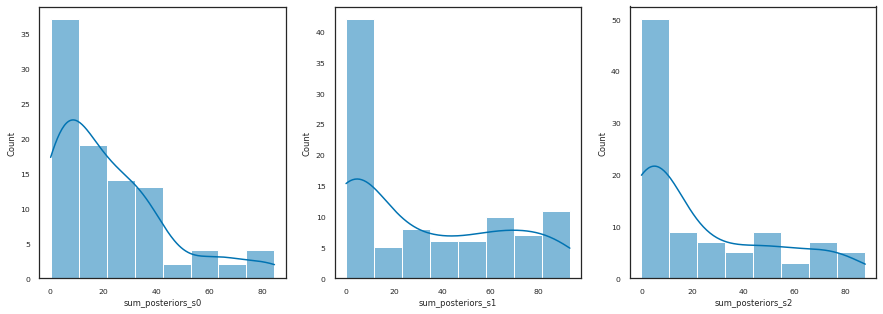

In [36]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

for i, ax in enumerate(axs):
    sns.histplot(x=posteriors[:,i], kde=True, ax=ax)
    ax.set_xlabel("sum_posteriors_s"+str(i))

### Create training dataset

In [10]:
# --- extract data of interest
X = np.vstack([ np.hstack((
    df_ema_enc[df_ema_enc.user == user][ema_cols].values,
    df_agg[df_agg.user == user].iloc[:,1::].values
)) for user in df_agg.user.unique() ])
y = np.asarray([ df_ema_enc[df_ema_enc.user == user]["Anxiety group"].values[0] for user in df_agg.user.unique() ])

cont_cols = -1 * np.arange(1, X.shape[1]-len(ema_cols)+1, 1)

k = 10


### Logistic regression

#### Training with K-fold CV

´scikit-learn´ provides an object called ´GridsearchCV´, that, given data, computes the score during the fit of an
estimator on a parameter grid and chooses the parameters to maximize the cross-validation score.

Two cross-validation loops are performed in parallel: one by the ´GridSearchCV´ estimator to set the hyper-parameters,
and the other one by ´cross_val_score´ to measure the prediction performance of the estimator. The resulting scores are
unbiased estimates of the prediction score on new data.

We apply K-fold cross validation on the data. Typical values for k are k=3, k=5, and k=10, with 10 representing the most
 common value. This is because, given extensive testing, 10-fold cross-validation provides a good balance of low
 computational cost and low bias in the estimate of model performance as compared to other k values and a single
 train-test split. Therefore, we will preform 10-Fold CV.

['/export/gts_usuarios/esukei/projects/anxiety_prediction/models/hmm_clf/cv_results_hmm3_n.p']

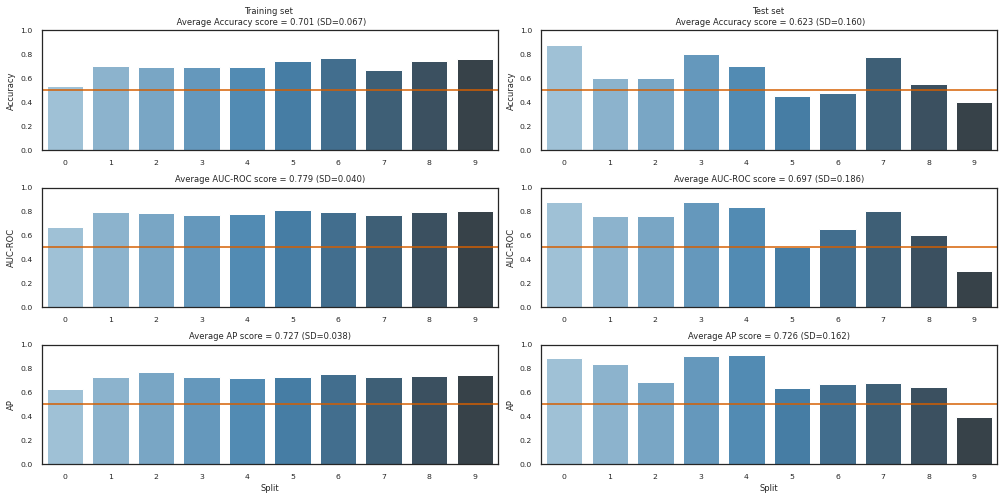

In [38]:
# define LR pipeline 
lr_pipeline = Pipeline([("scaler", MyStandardScaler(cont_cols)), 
                        ("lr", LogisticRegression(solver="saga", random_state=0, max_iter = 10000))])

# fit cv
cv_results = fit_kfold(lr_pipeline, lr_param_grid, X, y, k)

# plot evaluation metrics
plot_cv_scores(cv_results, ["Accuracy", "AUC-ROC", "AP"], figsize=(14,7))

# save cv results
jbl.dump(cv_results, PATH_TO_RESULTS+"cv_results_hmm3_n.p")

#### SHAP (SHapley Additive exPlanations)

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the
prediction.

In [49]:
import shap

X_sc = MyStandardScaler(cont_cols).fit_transform(X)
shap_values = []
for i in range(k):
    explainer = shap.LinearExplainer(cv_results["model"][i]["lr"], X_sc)
    shap_values.append(explainer.shap_values(X_sc))
    
shap_values = np.mean(np.asarray(shap_values), axis=0)

##### SHAP Feature Importance

The idea behind SHAP feature importance is simple: Features with large absolute Shapley values are important. Since we want the global importance, we average the absolute Shapley values per feature across the data:

$I_j = \sum_{i=1}^n |\phi_j^{(i)}|$

Next, we sort the features by decreasing importance and plot them.

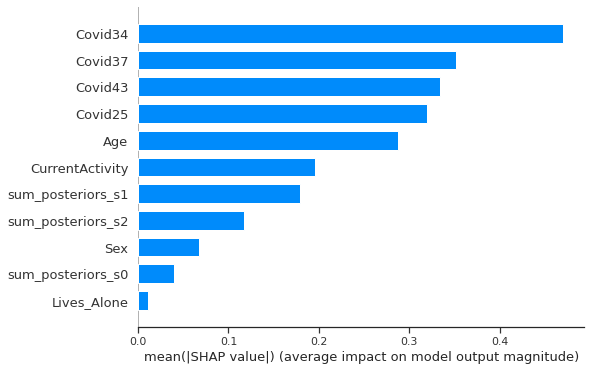

In [50]:
shap.summary_plot(shap_values, X_sc, feature_names=ema_cols_enc + df_agg.columns.to_list()[1::], plot_type="bar")


##### SHAP Summary Plot

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for
a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value.
The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction,
so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their
importance.

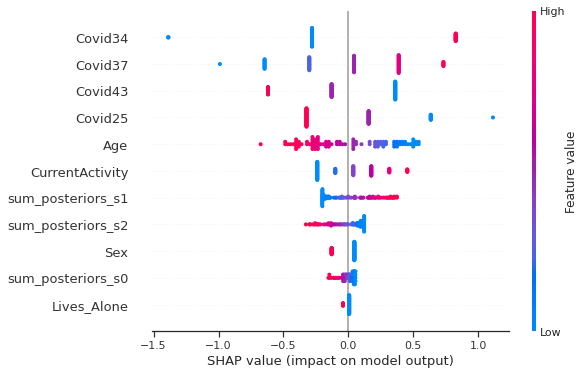

In [51]:
shap.summary_plot(shap_values, X_sc, feature_names=ema_cols_enc + df_agg.columns.to_list()[1::], show=False)
plt.savefig(PATH_TO_RESULTS+"shap_summary_n.pdf", dpi=300)

### Data distribution in each split

In [11]:
cv_results = jbl.load(PATH_TO_RESULTS+"cv_results_hmm3_n.p")

In [18]:
from src.utils import save_figures_to_pdf

x_cols = ema_cols + ["Σs_1", "Σs_2", "Σs_3"]
y_col = "Anxiety group"
temp_cols = ema_cols + ["Σs_1", "Σs_2", "Σs_3", "Anxiety group"]

X = np.vstack([ np.hstack((
    df_ema[df_ema.user == user][ema_cols].values,
    df_agg[df_agg.user == user].iloc[:,1::].values
)) for user in df_agg.user.unique() ])
y = np.asarray([ df_ema[df_ema.user == user]["Anxiety group"].values[0] for user in df_agg.user.unique() ])

figures = []
for i, row in cv_results.iterrows():
    # get data corresponding to the train-test split
    df_train = pd.DataFrame(
        data=np.hstack((X[row["train_idx"],:], y[row["train_idx"]].reshape(-1,1))),
        columns=temp_cols
    )
    df_test = pd.DataFrame(
        data=np.hstack((X[row["test_idx"],:], y[row["test_idx"]].reshape(-1,1))),
        columns=temp_cols
    )

    # get accuracy of split
    acc_tr, acc_tst = row["train_Accuracy"], row["test_Accuracy"]

    figures.append(
        plot_hmm_kfold_train_test_data(
            df_train, df_test, x_cols, y_col, acc_tr, acc_tst, i+1, figsize=(8, 16)
        )
    )
save_figures_to_pdf(figures, PATH_TO_RESULTS+"kfold_train_test_splits_n.pdf"))

### Random Forest Classifier

['/export/gts_usuarios/esukei/projects/anxiety_prediction/models/hmm_clf/cv_results_hmm3_rfc.p']

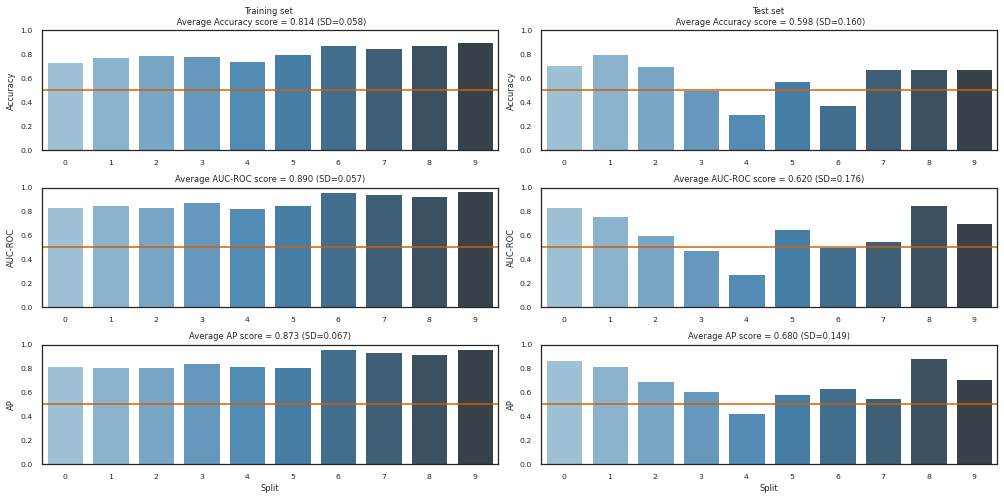

In [52]:
# define RF pipeline 
rfc_pipeline = Pipeline([("scaler", MyStandardScaler(cont_cols)), 
                         ("rfc", BalancedRandomForestClassifier(random_state=0))])

# fit cv
cv_results = fit_kfold(rfc_pipeline, rfc_param_grid, X, y, k)

# plot evaluation metrics
plot_cv_scores(cv_results, ["Accuracy", "AUC-ROC", "AP"], figsize=(14,7))

# save cv results
jbl.dump(cv_results, PATH_TO_RESULTS+"cv_results_hmm3_rfc.p")

## 5-state HMM
### Aggregate temporal data

In [53]:
# --- load HMM
hmm = hu.load_model(PATH_TO_HMM + "5_state_hmm.p")

# --- compute sum of HMM posteriors to summarize each sequence
posteriors = []
for seq in df_to_list(df_temp, data_columns):
    posteriors.append(np.sum(hmm.score_samples([seq])[0], axis=0))

posteriors=np.asarray(posteriors)

df_agg = pd.DataFrame(data = {
    "user": df_temp.user.unique(),
    "sum_posteriors_s0": posteriors[:,0],
    "sum_posteriors_s1": posteriors[:,1],
    "sum_posteriors_s2": posteriors[:,2],
    "sum_posteriors_s3": posteriors[:,3],
    "sum_posteriors_s4": posteriors[:,4],
})

df_agg.head()

,user,sum_posteriors_s0,sum_posteriors_s1,sum_posteriors_s2,sum_posteriors_s3,sum_posteriors_s4
0,1888,7.454382,10.378877,9.536379,15.591613,5.003875e+01
1,4170,13.317578,19.740713,3.267488,25.674221,2.878352e-44
2,5995,6.539847,8.485943,1.323908,0.650301,2.009738e-201
3,6050,22.625931,30.230660,5.139272,0.390341,3.461380e+01
4,7053,2.061585,6.406953,0.565111,72.751273,4.215079e+00


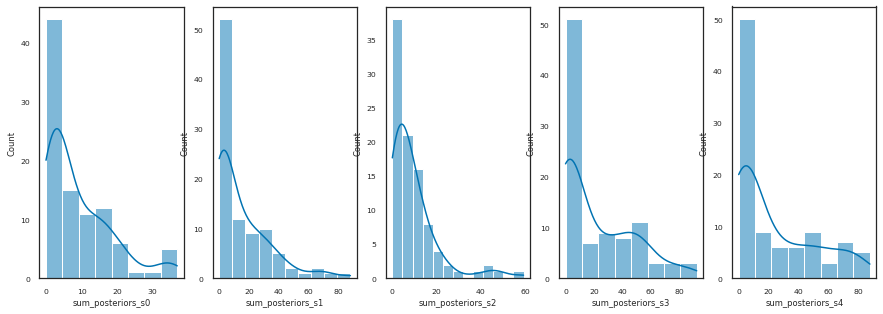

In [54]:
fig, axs = plt.subplots(1,5, figsize=(15,5))

for i, ax in enumerate(axs):
    sns.histplot(x=posteriors[:,i], kde=True, ax=ax)
    ax.set_xlabel("sum_posteriors_s"+str(i))

### Create training dataset

In [55]:
# --- extract data of interest
X = np.vstack([ np.hstack((
    df_ema_enc_enc[df_ema_enc_enc.user == user][ema_cols_enc].values,
    df_agg[df_agg.user == user].iloc[:,1::].values
)) for user in df_agg.user.unique() ])
y = np.asarray([ df_ema_enc_enc[df_ema_enc_enc.user == user]["Anxiety_Group"].values[0] for user in df_agg.user.unique() ])

cont_cols = -1 * np.arange(1, X.shape[1]-len(ema_cols_enc)+1, 1)

k = 10

### Logistic regression

#### Training with K-fold CV

´scikit-learn´ provides an object called ´GridsearchCV´, that, given data, computes the score during the fit of an
estimator on a parameter grid and chooses the parameters to maximize the cross-validation score.

Two cross-validation loops are performed in parallel: one by the ´GridSearchCV´ estimator to set the hyper-parameters,
and the other one by ´cross_val_score´ to measure the prediction performance of the estimator. The resulting scores are
unbiased estimates of the prediction score on new data.

We apply K-fold cross validation on the data. Typical values for k are k=3, k=5, and k=10, with 10 representing the most
 common value. This is because, given extensive testing, 10-fold cross-validation provides a good balance of low
 computational cost and low bias in the estimate of model performance as compared to other k values and a single
 train-test split. Therefore, we will preform 10-Fold CV.

['/export/gts_usuarios/esukei/projects/anxiety_prediction/models/hmm_clf/cv_results_hmm5_n.p']

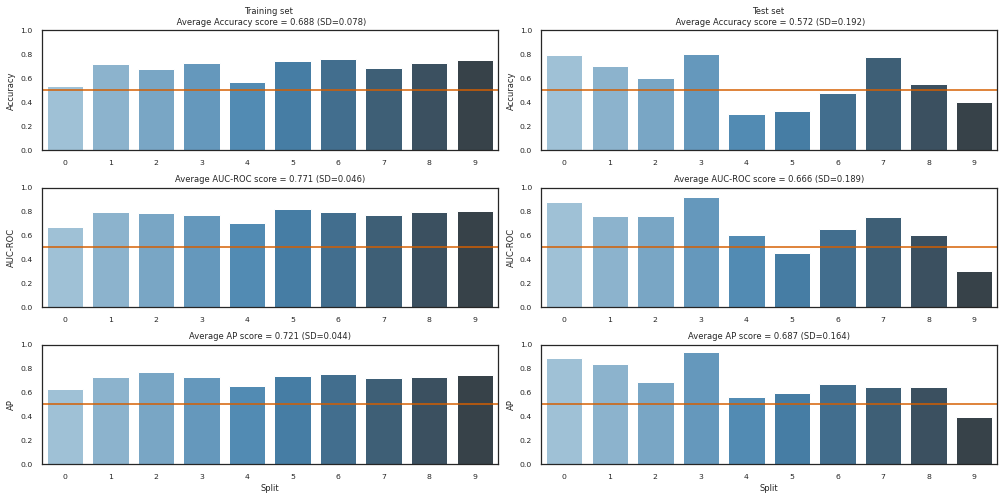

In [56]:
# define LR pipeline 
lr_pipeline = Pipeline([("scaler", MyStandardScaler(cont_cols)), 
                        ("lr", LogisticRegression(random_state=0, max_iter = 10000))])

# fit cv
cv_results = fit_kfold(lr_pipeline, lr_param_grid, X, y, k)

# plot evaluation metrics
plot_cv_scores(cv_results, ["Accuracy", "AUC-ROC", "AP"], figsize=(14,7))

# save cv results
jbl.dump(cv_results, PATH_TO_RESULTS+"cv_results_hmm5_n.p")

#### SHAP (SHapley Additive exPlanations)

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the
prediction.

In [57]:
import shap

X_sc = MyStandardScaler(cont_cols).fit_transform(X)
shap_values = []
for i in range(k):
    explainer = shap.LinearExplainer(cv_results["model"][i]["lr"], X_sc)
    shap_values.append(explainer.shap_values(X_sc))
    
shap_values = np.mean(np.asarray(shap_values), axis=0)

##### SHAP Feature Importance

The idea behind SHAP feature importance is simple: Features with large absolute Shapley values are important. Since we want the global importance, we average the absolute Shapley values per feature across the data:

$I_j = \sum_{i=1}^n |\phi_j^{(i)}|$

Next, we sort the features by decreasing importance and plot them.

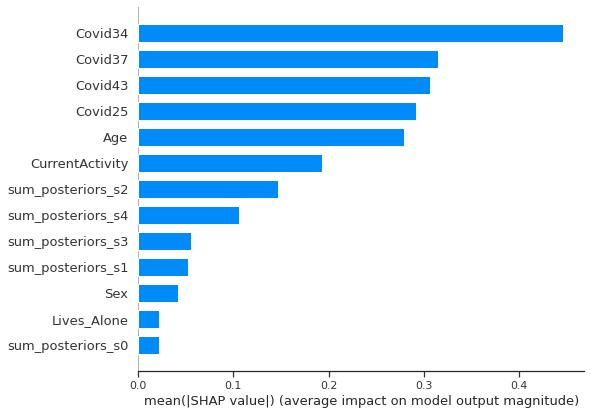

In [58]:
shap.summary_plot(shap_values, X_sc, feature_names=ema_cols_enc + df_agg.columns.to_list()[1::], plot_type="bar")


##### SHAP Summary Plot

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for
a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value.
The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction,
so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their
importance.

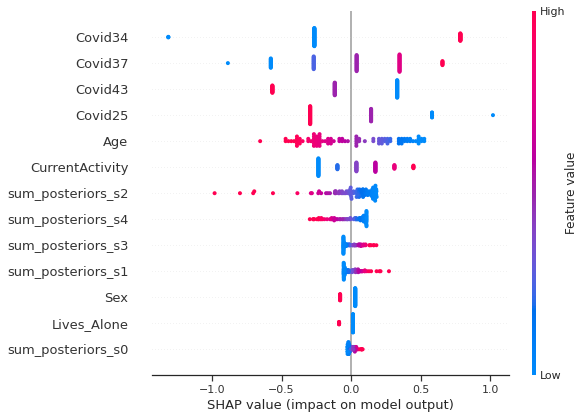

In [59]:
shap.summary_plot(shap_values, X_sc, feature_names=ema_cols_enc + df_agg.columns.to_list()[1::])

### Random Forest Classifier

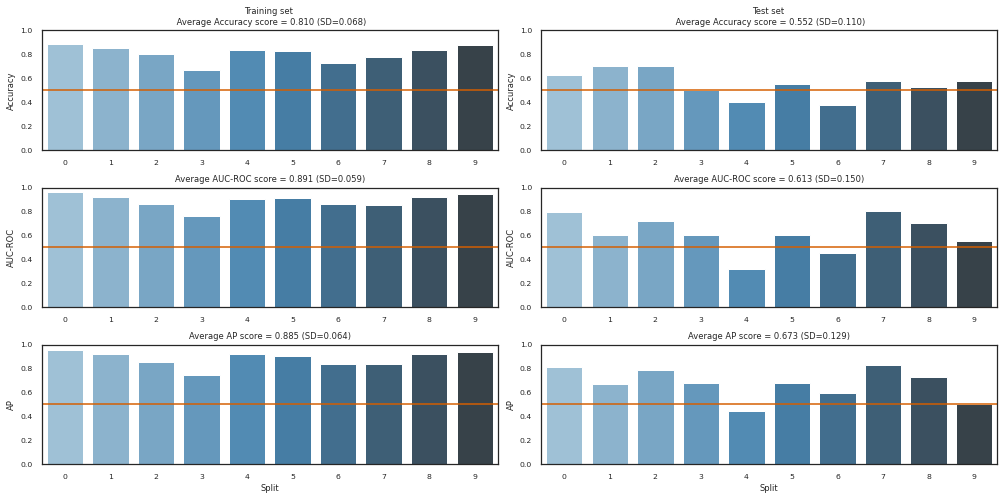

In [60]:
# define RF pipeline 
rfc_pipeline = Pipeline([("scaler", MyStandardScaler(cont_cols)), 
                         ("rfc", BalancedRandomForestClassifier(random_state=0))])

# fit cv
cv_results = fit_kfold(rfc_pipeline, rfc_param_grid, X, y, k)

# plot evaluation metrics
plot_cv_scores(cv_results, ["Accuracy", "AUC-ROC", "AP"], figsize=(14,7))